# Logistic Regression Assumptions

In [215]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import math
from sklearn.linear_model import LogisticRegression
from scipy import stats

import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")


In [216]:
# Load cleaned data
listings_df = pd.read_csv(os.path.join('data', 'yvr_listing_data_cleaned.csv'))

In [228]:
## Assumption 1 — No strongly influential outliers

# Use GLM method for logreg here so that we can retrieve the influence measures
X_cols = listings_df.columns.to_list()[:-1]
X = listings_df[X_cols].drop(['room_type_Hotel room', 'room_type_Shared room'], axis=1)
y = listings_df['legal_listing']

# Add constant
X = sm.add_constant(X, prepend=False)

# Re-run logistic regression on original set of X and y variables
logit_results = GLM(y, X, family=families.Binomial()).fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          legal_listing   No. Observations:                 2599
Model:                            GLM   Df Residuals:                     2557
Model Family:                Binomial   Df Model:                           41
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -370.17
Date:                Sun, 10 Dec 2023   Deviance:                       740.35
Time:                        13:29:42   Pearson chi2:                 2.53e+03
No. Iterations:                    24   Pseudo R-squ. (CS):            0.06355
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [218]:
# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook distance
diagnosis_df = summ_df.loc[:,['cooks_d']]

# Append absolute standardized residual values
diagnosis_df['std_resid'] = stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df.loc[:,'std_resid'].apply(lambda x: np.abs(x))

# Sort by Cook's Distance
diagnosis_df.sort_values("cooks_d", ascending=False)
diagnosis_df.head()
     

,cooks_d,std_resid
0,1.633449e-05,0.175486
1,5.786688e-07,0.085056
2,1.349093e-17,0.003869
3,1.031504e-05,0.202831
4,2.065920e-07,0.049122


Threshold for Cook Distance = 0.0015390534821085034


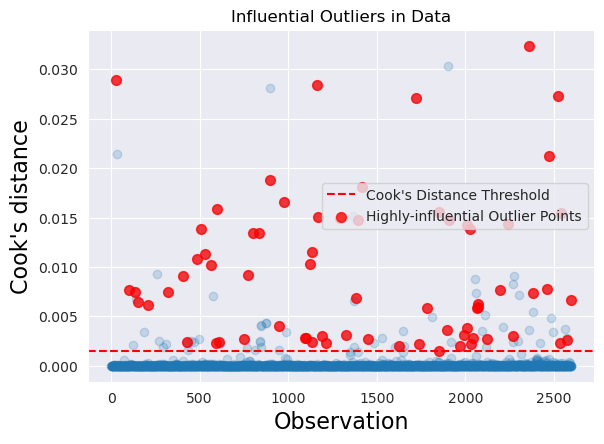

In [219]:
# Set Cook's distance threshold
cook_threshold = 4 / len(listings_df)
print(f"Threshold for Cook Distance = {cook_threshold}")

# Plot influence measures (Cook's distance)
fig, ax = plt.subplots()
influence.plot_index(y_var="cooks", threshold=cook_threshold, ax=ax, alpha=0.2)  # Set alpha here
axhline = ax.axhline(y=cook_threshold, ls="--", color='red')

# Remove existing labels
for text in ax.texts:
    text.set_visible(False)

# Highlight points with std_resid > 3
highlight_indices = diagnosis_df[diagnosis_df['std_resid'] > 3].index
scatter = ax.scatter(
    highlight_indices,
    diagnosis_df.loc[highlight_indices, 'cooks_d'],
    color='red',  # Set a color for the highlighted points
    marker='o',   # Set a marker style for the highlighted points
    alpha=0.75,    # Set transparency for the highlighted points
    s=50          # Set marker size
)


fig.tight_layout(pad=2)

plt.legend([axhline, scatter], ['Cook\'s Distance Threshold', 'Highly-influential Outlier Points'], loc='center right')

plt.title("Influential Outliers in Data")

fig.tight_layout(pad=2)
plt.savefig('outliers.png', transparent=True)
plt.show()

In [220]:
# Find number of observations that exceed Cook's distance threshold
outliers = diagnosis_df[diagnosis_df['cooks_d'] > cook_threshold]
prop_outliers = round(100*(len(outliers) / len(listings_df)),1)
print(f'Proportion of data points that are highly influential = {prop_outliers}%')

Proportion of data points that are highly influential = 4.7%


In [225]:
# Find number of observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)]
prop_extreme = round(100*(len(extreme) / len(listings_df)),1)
# Display top most influential outliers
extreme_index=extreme.sort_values("cooks_d", ascending=False)
extreme_index.index

Index([2358,   28, 1162, 2521, 1721, 2474,  897, 1414,  975,  595, 1850, 2540,
       1165, 1292, 1395, 1907, 2241, 2010, 2027,  508,  802,  833, 1133,  527,
        485, 1121,  561,  774,  405, 2462,  100, 2197,  136,  319, 2381, 1382,
       2596,  153, 2071,  206, 2072, 2064, 1784,  948, 2006, 1897, 1993, 1323,
       2269, 1188, 1095, 2040, 1098,  747, 1448, 2120, 2574, 1136,  608,  427,
       1213, 2534,  594, 1736, 2031, 1971, 1622],
      dtype='int64')

In [224]:
# Deep dive into index 2358 (extreme outlier)
print(listings_df.iloc[2358])

host_response_time                                   0.5
host_response_rate                                  80.0
review_scores_value                                  5.0
has_availability                                     1.0
availability_365                                   224.0
host_verifications                                   0.5
host_acceptance_rate                               100.0
minimum_nights                                       9.0
host_is_superhost                                    0.0
beds                                                 1.0
availability_30                                      0.0
number_of_reviews_l30d                               0.0
calculated_host_listings_count_entire_homes          1.0
calculated_host_listings_count_private_rooms         0.0
host_has_profile_pic                                 0.0
host_identity_verified                               1.0
number_of_reviews                                    1.0
price                          

In [226]:
# delete all the high influential outliers row
listings_df_fixed = listings_df.drop([2358,   28, 1162, 2521, 1721, 2474,  897, 1414,  975,  595, 1850, 2540,
       1165, 1292, 1395, 1907, 2241, 2010, 2027,  508,  802,  833, 1133,  527,
        485, 1121,  561,  774,  405, 2462,  100, 2197,  136,  319, 2381, 1382,
       2596,  153, 2071,  206, 2072, 2064, 1784,  948, 2006, 1897, 1993, 1323,
       2269, 1188, 1095, 2040, 1098,  747, 1448, 2120, 2574, 1136,  608,  427,
       1213, 2534,  594, 1736, 2031, 1971, 1622], axis=0)

# check if they are deleted
origin_row = listings_df.shape[0]
fixed_row = listings_df_fixed.shape[0]

print(f'the fixed row is {fixed_row}; the origin row is {origin_row}.\nThere are {origin_row - fixed_row} rows have been deleted.')

the fixed row is 2532; the origin row is 2599.
There are 67 rows have been deleted.


In [184]:
## Assumption 2 — Linearity of independent variables and log-odds
# This assumption means that relationships between the continuous predictors and the logit (log odds) is linear.
# So the continuous variable should be filtered mannually
# Box Tidwell only works for positive values. Hence, drop values where x = 0
var = listings_df_fixed.columns.tolist()
continuous_var = ['price','host_response_rate',"review_scores_cleanliness"]
df_yvr_1 = listings_df_fixed.drop(listings_df_fixed[listings_df_fixed.price == 0].index)
df_yvr_1 = df_yvr_1.drop(listings_df_fixed[listings_df_fixed.host_response_rate == 0].index)
df_yvr_1 = df_yvr_1.drop(listings_df_fixed[listings_df_fixed.review_scores_checkin == 0].index)
df_yvr_1 = df_yvr_1.drop(listings_df_fixed[listings_df_fixed.review_scores_cleanliness == 0].index)
print(df_yvr_1[['price','host_response_rate','review_scores_cleanliness','legal_listing']].head(10))

   price  host_response_rate  review_scores_cleanliness  legal_listing
0  215.0               100.0                       4.81            1.0
1  150.0               100.0                       4.96            0.0
2  135.0               100.0                       4.93            1.0
3  143.0               100.0                       4.74            1.0
4  100.0               100.0                       4.87            1.0
5  300.0               100.0                       5.00            1.0
6  169.0               100.0                       4.74            0.0
7  127.0               100.0                       4.44            0.0
8  175.0               100.0                       4.99            1.0
9  125.0               100.0                       4.83            1.0


In [185]:
# Logistic Regression with statsmodel 
# Inclusion of interaction term (logit transform) as part of Box-Tidwell test

df_yvr_lt = df_yvr_1 .copy()

# Add logit transform interaction terms (natural log) for continuous variables e.g. Age * Log(Age)
for var in continuous_var:
    df_yvr_lt[f'{var}:mLog_{var}'] = df_yvr_lt[var].apply(lambda x: x * np.log(x)) #np.log = natural log

df_yvr_lt.head()

,minimum_nights,host_response_rate,host_is_superhost,number_of_reviews,price,availability_30,number_of_reviews_l30d,beds,host_total_listings_count,availability_365,...,neighbourhood_cleansed_Victoria-Fraserview,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Point Grey,room_type_Hotel room,room_type_Private room,room_type_Shared room,legal_listing,price:mLog_price,host_response_rate:mLog_host_response_rate,review_scores_cleanliness:mLog_review_scores_cleanliness
0,1.0,100.0,0.0,476.0,215.0,4.0,4.0,1.0,1.0,108.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1154.687176,460.517019,7.555053
1,30.0,100.0,1.0,99.0,150.0,9.0,0.0,1.0,4.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,751.595294,460.517019,7.942972
2,30.0,100.0,0.0,269.0,135.0,5.0,1.0,1.0,4.0,124.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,662.212095,460.517019,7.865021
3,30.0,100.0,0.0,51.0,143.0,4.0,1.0,1.0,5.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,709.686782,460.517019,7.375616
4,30.0,100.0,1.0,230.0,100.0,6.0,1.0,1.0,4.0,155.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,460.517019,460.517019,7.709667


In [186]:
# Keep columns related to continuous variables
cols_to_keep = continuous_var + df_yvr_lt.columns.tolist()[-len(continuous_var):]
cols_to_keep

# Redefine independent variables to include interaction terms
X_lt = df_yvr_lt[cols_to_keep]
y_lt = df_yvr_lt['legal_listing']

X_lt = sm.add_constant(X_lt, prepend=False)

# # Build model and fit the data (using statsmodel's Logit)
# logit_results = GLM(y_lt, X_lt, family=families.Binomial()).fit()

# Build model and fit the data (using statsmodel's Logit)
logit_model = sm.Logit(y_lt, X_lt)
logit_results = logit_model.fit(maxiter=100000)

# Display summary results
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.471266
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          legal_listing   No. Observations:                 3559
Model:                          Logit   Df Residuals:                     3552
Method:                           MLE   Df Model:                            6
Date:                Sat, 09 Dec 2023   Pseudo R-squ.:                 0.09763
Time:                        17:13:42   Log-Likelihood:                -1677.2
converged:                       True   LL-Null:                       -1858.7
Covariance Type:            nonrobust   LLR p-value:                 2.589e-75
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
price           

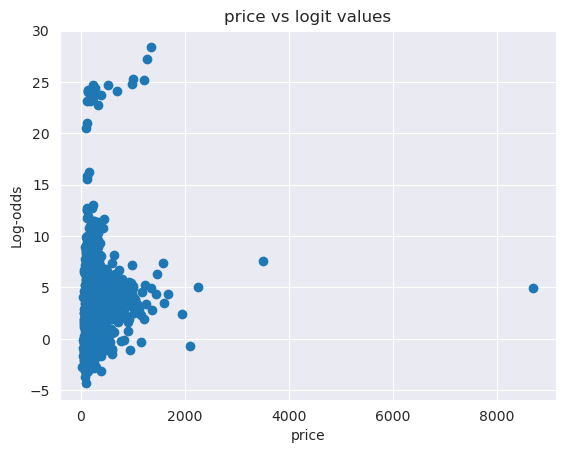

In [187]:
# Visual Check
# Define dependent and independent variables
X_cols = listings_df.columns.to_list()[:-1]
X = listings_df[X_cols].drop(['room_type_Hotel room', 'room_type_Shared room'], axis=1)
y = listings_df['legal_listing']

# Add constant
X = sm.add_constant(X, prepend=False)

# Re-run logistic regression on original set of X and y variables
logit_results = GLM(y, X, family=families.Binomial()).fit()
predicted = logit_results.predict(X)

# Get log odds values
log_odds = np.log(predicted / (1 - predicted))

# Visualize predictor continuous variable vs logit values (Age)
plt.scatter(x = listings_df['price'].values, y = log_odds);
plt.title("price vs logit values")
plt.xlabel("price")
plt.ylabel("Log-odds")
plt.show()
# Confirming that there is no logit linearity for the 'price' variable 

In [199]:
# the 'price' violates the assumption, 
# so we need to transform them so that find the transformation that could fit the relationship with logit-odds

# replace price value with their log tansformation
listings_df_0 = listings_df.copy()
listings_df_0['log_price'] = listings_df_0['price'].apply(lambda x: np.log(x) if x !=0 else 0)
listings_df_0 = listings_df_0.drop(['price','review_scores_checkin','room_type_Hotel room','room_type_Shared room'], axis=1)

# fit the logistic regression model
X_0 = listings_df_0.drop('legal_listing', axis=1)
y_0 = listings_df_0['legal_listing']
X_0 = sm.add_constant(X_0)

logit_model_0 = sm.Logit(y_0, X_0)
result_0 = logit_model_0.fit()
print(result_0.summary())

# The linearity relation of 'review_scores_checkin' can be built by using logarithmic multiplication transformation,  (the p-value of 'log_review_scores_checkin' is 0.039 less than 0.05) 
# The linearity relation of 'price' can be built by using log transformation,  (the p-value of 'log_price' is 0.039 less than 0.05) 

         Current function value: 0.259314
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:          legal_listing   No. Observations:                 3583
Model:                          Logit   Df Residuals:                     3541
Method:                           MLE   Df Model:                           41
Date:                Sat, 09 Dec 2023   Pseudo R-squ.:                  0.5078
Time:                        17:20:18   Log-Likelihood:                -929.12
converged:                      False   LL-Null:                       -1887.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                                               0.0238      1.563 

In [200]:
# Move the transformed colunms to head
listings_df_0 = listings_df_0[['log_price'] + 
                               [col for col in listings_df_0.columns if col not in ['log_price']]]
listings_df_0

,log_price,minimum_nights,host_response_rate,host_is_superhost,number_of_reviews,availability_30,number_of_reviews_l30d,beds,host_total_listings_count,availability_365,...,neighbourhood_cleansed_Riley Park,neighbourhood_cleansed_Shaughnessy,neighbourhood_cleansed_South Cambie,neighbourhood_cleansed_Strathcona,neighbourhood_cleansed_Sunset,neighbourhood_cleansed_Victoria-Fraserview,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Point Grey,room_type_Private room,legal_listing
0,5.370638,1.0,100.0,0.0,476.0,4.0,4.0,1.0,1.0,108.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,5.010635,30.0,100.0,1.0,99.0,9.0,0.0,1.0,4.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.905275,30.0,100.0,0.0,269.0,5.0,1.0,1.0,4.0,124.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4.962845,30.0,100.0,0.0,51.0,4.0,1.0,1.0,5.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4.605170,30.0,100.0,1.0,230.0,6.0,1.0,1.0,4.0,155.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3578,5.298317,2.0,100.0,0.0,1.0,15.0,1.0,4.0,1.0,74.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3579,5.147494,1.0,100.0,0.0,2.0,7.0,2.0,2.0,1.0,146.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3580,5.991465,2.0,94.0,0.0,1.0,26.0,1.0,2.0,3.0,361.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3581,5.771441,2.0,100.0,0.0,1.0,21.0,1.0,2.0,1.0,81.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [208]:
# Applying Box-Tidwell test to the fixed dataset
var_1 = listings_df_0.columns.tolist()
continuous_var_1 = ['log_price']

listings_df_1 = listings_df_0.copy()

# Add logit transform interaction terms (natural log) for continuous variables e.g. Age * Log(Age)
for var in continuous_var_1:
    listings_df_1[f'{var}:Log_{var}'] = listings_df_1[var].apply(lambda x: x * np.log(x)) #np.log = natural log

# Keep columns related to continuous variables
cols_to_keep_1 = continuous_var_1 + listings_df_1.columns.tolist()[-len(continuous_var_1):]
cols_to_keep_1

# delete the influential outliers checked in assumption 1
listings_df_1 = listings_df_1.drop([1724, 57, 844, 833, 499, 1459, 629, 1903, 1727, 1102, 1630, 1759, 1794, 882], axis=0)

# Redefine independent variables to include interaction terms
X_1 = listings_df_1[cols_to_keep_1]
y_1 = listings_df_1['legal_listing']
X_1 = sm.add_constant(X_1)

# Build model and fit the data (using statsmodel's Logit)
logit_model_1 = sm.Logit(y_1, X_1)
logit_results_1 = logit_model_1.fit()

# Display summary results
print(logit_results_1.summary())

Optimization terminated successfully.
         Current function value: 0.474680
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          legal_listing   No. Observations:                 3569
Model:                          Logit   Df Residuals:                     3566
Method:                           MLE   Df Model:                            2
Date:                Sat, 09 Dec 2023   Pseudo R-squ.:                 0.09287
Time:                        17:28:18   Log-Likelihood:                -1694.1
converged:                       True   LL-Null:                       -1867.6
Covariance Type:            nonrobust   LLR p-value:                 4.780e-76
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -20.8641      7.543     -2.766      0.006     -35.647   

Slope: 4.003996413544637
Intercept: -5.978748931256307
R-squared: 0.04680084162112846
P-value: 4.5943851475245436e-39
Standard Error: 0.30255693968400726


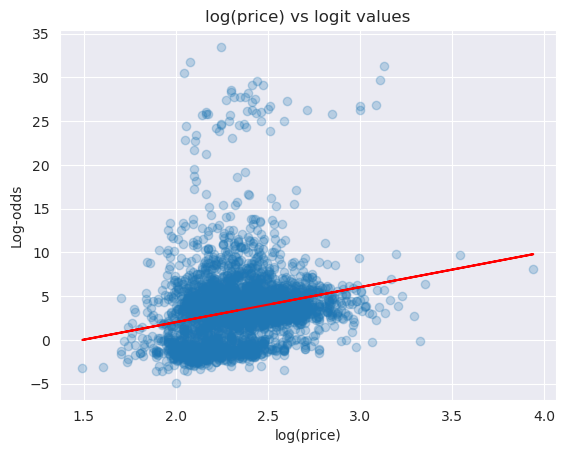

In [210]:
# Visual Check
# Define dependent and independent variables
# listings_df_fixed = listings_df.drop([1724, 57, 844, 833, 499, 1459, 629, 1903, 1727, 1102, 1630, 1759, 1794, 882], axis=0)

X_cols = listings_df_fixed.columns.to_list()[:-1]
X = listings_df_fixed[X_cols].drop(['room_type_Hotel room', 'room_type_Shared room'], axis=1)
y = listings_df_fixed['legal_listing']

# Add constant
X = sm.add_constant(X, prepend=False)

# Re-run logistic regression on original set of X and y variables
logit_results = GLM(y, X, family=families.Binomial()).fit()
predicted = logit_results.predict(X)


# Get log odds values
log_odds = np.log(predicted / (1 - predicted))

# Calculate linear regression between log(price) and logit values
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(listings_df_fixed['price'].values), log_odds)

# Print the results
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)
print("P-value:", p_value)
print("Standard Error:", std_err)

# Visualize predictor continuous variable vs logit values (Price)
plt.scatter(x = np.log10(listings_df_fixed['price'].values), y = log_odds, alpha = 0.25);
plt.title("log(price) vs logit values")
plt.xlabel("log(price)")
plt.ylabel("Log-odds")

# Add the slope line
x = np.log10(listings_df_fixed['price'].values)
y = slope * x + intercept
plt.plot(x, y, color='red')

plt.savefig('log_price_vs_logit.png', transparent=True)
plt.show()

In [211]:
# save the fixed data into csv
listings_df_1.to_csv('data/yvr_listing_data_cleaned_fixed.csv', index=False)